# Use feature engineering and Visual AI with acoustic data

**Author**: Kyle Lindgren

**Version Date**: 2023-03-15

## Summary

This example notebook shows how to generate image features in addition to aggregate numeric features for high frequency data sources. While similar to the Gramian Angular Field (GAF) approach of converting temporal signals to images (<a href='https://github.com/datarobot-community/ai-accelerators/blob/main/game-changer/high_freq_data_to_images/high_frequency_data_classification_using_gramian_angular_fields.ipynb'>GAF notebook</a>), this notebook converts audio wav files into the frequency domain to generate spectrograms. Statistical numeric features computed from the converted signal add additional descriptors of the signal to aid classification of the audio source. Converting high frequency data into image representations enables use of well-established computer vision techniques for complex data understanding. See below for an example of an audio signal converted from the time domain to the frequency domain.

<center><h3>Spectrogram representation of an audio signal</h3>

</center>

<!-- <img src="imgs/spectrogram_audioform_sample.png" width="800" /> -->

![](imgs/spectrogram_audioform_sample.png)

## Topics
This notebook demonstrates the value of image representations of audio signals for an environment classification use case, covering:

1. Data preparation
2. Modeling
3. Model evaluation

For more information on how to run Visual AI projects with DataRobot's Python client, refer to <a href='https://datarobot-public-api-client.readthedocs-hosted.com/en/latest-release/reference/modeling/spec/visualai.html'>DataRobot's documentation</a>.


## Setup

### Import libraries

Access the following Python libraries using the links below:

- <a href='https://datarobot-public-api-client.readthedocs-hosted.com/en/v3.0.2/'>datarobot</a>
- <a href='https://librosa.org/doc/latest/index.html'> librosa </a>

In [ ]:
# install all necessary Python packages
!pip install -r requirements.txt

In [1]:
import os
from io import BytesIO
from collections import defaultdict
import base64
import urllib.request
import getpass
import zipfile
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import seaborn as sns
import datarobot as dr
from datarobot.models.visualai import ImageActivationMap
from create_features import Featurizer
from helpers import plot_feature_impacts, show_specs, get_top_of_leaderboard

### Connect to DataRobot

Read more about different options for [connecting to DataRobot from the Python client](https://docs.datarobot.com/en/docs/api/api-quickstart/api-qs.html).

In [2]:
ENDPOINT='https://app.datarobot.com/api/v2'
try:
    token = getpass.getpass()
except Exception as error:
    print('ERROR', error)
    
dr_client = dr.Client(endpoint=ENDPOINT, token=token)

 ········


In [3]:
dr_client.verify

True

## 1. Data Preparation

The [ESC-50 dataset](https://github.com/karolpiczak/ESC-50) is a labeled collection of 2000 environmental audio recordings suitable for benchmarking methods of environmental sound classification.

The dataset consists of 5-second long (44.1 kHz, mono) recordings organized into 50 semantical classes (with 40 examples per class) loosely arranged into 5 major categories. This notebook uses a subset (clips tagged as ESC-10) of this dataset distributed under CC BY (Attribution). The 10 classes arranged by their major category are:

| <sub>Animals</sub> | <sub>Natural soundscapes & water sounds </sub> | <sub>Human, non-speech sounds</sub> | <sub>Interior/domestic sounds</sub> | <sub>Exterior/urban noises</sub> |
| :--- | :--- | :--- | :--- | :--- |
| <sub>Dog</sub> | <sub>Rain</sub> | <sub>Crying baby</sub> | <sub>Clock tick</sub> | <sub>Helicopter</sub></sub> |
| <sub>Rooster</sub> | <sub>Sea waves</sub> | <sub>Sneezing</sub> |  | <sub>Chainsaw</sub> |
|  | <sub>Crackling fire</sub> |  |  |  |

The raw `.wav` files are stored in the `audio10` directory with the filename structure

  `{FOLD}-{CLIP_ID}-{TAKE}-{TARGET}.wav`

  - `{FOLD}` - index of the cross-validation fold,
  - `{CLIP_ID}` - ID of the original Freesound clip,
  - `{TAKE}` - letter disambiguating between different fragments from the same Freesound clip,
  - `{TARGET}` - class in numeric format [0, 49].
  
`esc10.csv` contains the dataset meta information:

  | <sub>filename</sub> | <sub>fold</sub> | <sub>category</sub> | <sub>src_file</sub> | <sub>take</sub> |
  | :--- | :--- | :--- | :--- | :--- |
  
Where `category` is the target class name.

The `audio10` folder and `esc10.csv` file will be downloaded in a later cell.

### Prepare a multiclass image dataset for upload to DataRobot
For more information on creating image datasets for DataRobot please refer to <a href='https://www.datarobot.com/blog/getting-your-image-data-ready-for-visual-ai/'>DataRobot's blogpost</a>.

In [2]:
# define dataset filenames
meta_file = "esc10.csv"  # contains labels and partitions features
data_dir = "audio10"  # directory to hold source audio data
data_zip = data_dir+".zip"

# define data parameters
n_fft = 2048  # samples per frame for STFT/spectrogram
sr = 44100  # sampling rate

In [3]:
# import meta file (~15 KB)
urllib.request.urlretrieve(f"https://s3.amazonaws.com/datarobot_public_datasets/{meta_file}", 
                           meta_file)

('esc10.csv', <http.client.HTTPMessage at 0x10bb76b20>)

In [4]:
# import dataset metadata
esc10_df = pd.read_csv(meta_file)
esc10_df

,filename,fold,category,src_file,take
0,1-100032-A-0.wav,1,dog,100032,A
1,1-110389-A-0.wav,1,dog,110389,A
2,1-116765-A-41.wav,1,chainsaw,116765,A
3,1-17150-A-12.wav,1,crackling_fire,17150,A
4,1-172649-A-40.wav,1,helicopter,172649,A
...,...,...,...,...,...
395,5-233160-A-1.wav,5,rooster,233160,A
396,5-234879-A-1.wav,5,rooster,234879,A
397,5-234879-B-1.wav,5,rooster,234879,B
398,5-235671-A-38.wav,5,clock_tick,235671,A


In [5]:
print('fold values:', esc10_df.fold.unique())
print('category values:', esc10_df.category.unique())

fold values: [1 2 3 4 5]
category values: ['dog' 'chainsaw' 'crackling_fire' 'helicopter' 'rain' 'crying_baby'
 'clock_tick' 'sneezing' 'rooster' 'sea_waves']


In [6]:
# import source audio data zip folder (~123 MB)
urllib.request.urlretrieve(f"https://s3.amazonaws.com/datarobot_public_datasets/{data_zip}", 
                           data_zip)

('audio10.zip', <http.client.HTTPMessage at 0x1068f0b50>)

In [7]:
# extract source .wav files
with zipfile.ZipFile(data_zip, "r") as zip_ref:
    zip_ref.extractall("./")
    
lst = os.listdir(data_dir)
number_files = len(lst)
print(number_files)  # 400 files, 40 samples for each of the 10 target classes

400


### Feature engineering for audio recordings

#### Images
The GAF approach similarly leverages well-established computer vision techniques in the machine learning space by converting high frequency time series data into dense image representations which help capture correlations between distant data points. This is achieved in a two step process: convert the time series data into polar coordinates and then construct an image by computing the cosine of the sum of the angles for each data point pair. 

This notebook converts a time series signal to a spectrogram - image representations in the time-frequency domain - using the short-time Fourier transform (STFT). The STFT convolves the time series with a windowing function, applying the Fourier transform to each window. The spectrogram images here are constructed by converting the STFT result amplitude to decibels and plotting with a logarithmic y-axis to capture the details of low frequencies while still including high frequency extremes. In addition to the **full spectrogram**, 3 spectrogram variations are computed to characterize the data by emphasizing different components:
- **Mel Spectrogram**: Uses the mel scale, a non-linear transformation of frequency based on the perception of pitches. Qualitatively, the rescaling results in any two pairs of frequencies separated by a delta in the mel scale being perceived by humans as being equidistant.
- **Decomposed Spectrogram** into its harmonic and percussive components with the harmonic spectrogram extracting pitched sounds (perceived as melodies and chords) and the percussive spectrogram extracting short and loud sounds.
    - **Harmnonic**: Estimates the fundamental frequency (f0) at each time step and extracts the energy at integer multiples of f0 (the harmonics).
    - **Percussive**: Assigns energy to time-frequency bins according to the response of a vertical filter. 

#### Numerics
Several descriptive numerics are also computed from the **full spectrogram**.
- **Chroma features**: aggregates the distribution of energy across a signal in a predefined set of 12 pitch classes.
- **MFCCs**: Mel Frequency Cepstral Coefficients model the spectral energy distribution in a perceptually meaningful way. 
- **MFCCs 1st and 2nd delta**: mean of the first and second derivative of the MFCCs. 
- **Spectral centroid**: center of gravity of the sound spectrum.
- **Spectral centroid delta**: local estimate of the derivative of the spectral centroid.
- **Spectral rolloff**: frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
- **Spectral flatness**: quantifies how much noise-like a sound is, as opposed to being tone-like
- **Spectral bandwidth**: the p'th-order frequency bandwidth for each frame. Here we use p in [2,3,4].

Lastly, for each of the spectral characteristics above, the following 18 descriptive stats are computed: mean, standar error, confidence interval, standard deviation, interquartile range, interquartile range relative to a Normal, mean absolute deviation, mean absolute deviation relative to a Normal, coefficient of variation, range between max and min, max, min, skewness, kurtosis, Jarque-Bera, mode, frequency of the common points, and median.

In [6]:
features_dd = defaultdict(list) 

featurizer = Featurizer()
for index, row in tqdm(esc10_df.iterrows(), total=esc10_df.shape[0]):
    # load audio file as floating point time series
    y, sr_ = librosa.load(os.path.join(data_dir, row['filename']), sr=sr)
    
    # create featurizing object
    featurizer.__init__(array=y, sr=sr, n_fft=n_fft)

    # 4 kinds of spectrogram images are created and converted to base64 strings (for direct upload to the DataRobot platform)
    spectrograms = featurizer._create_all_spectrograms()
    # 500+ numerics are computed from the full spectrogram
    spectral_features = featurizer._create_all_spectral_features()

    for k, v in spectrograms.items():
        features_dd[k].append(v)
    for k, v in spectral_features.items():
        features_dd[k].append(v)
    features_dd['filename'].append(row['filename'])

100%|████████████████████████████████████████████████████████████████████████████████████████| 400/400 [13:35<00:00,  2.04s/it]


In [8]:
# convert features default dict to pandas dataframe
features_df = pd.DataFrame.from_dict(features_dd)
features_df.shape

(400, 541)

In [12]:
# combine features dataframe with meta dataframe
dataset_df = pd.concat([esc10_df.set_index('filename'), features_df.set_index('filename')], axis=1, join='inner')
dataset_df

,fold,category,src_file,take,spectrogram,spectrogram_mel,spectrogram_harmonic,spectrogram_percussive,chroma_0,chroma_1,...,feat_spectral_centroid_delta_min,feat_spectral_centroid_delta_skew,feat_spectral_centroid_delta_kurtosis,feat_spectral_centroid_delta_iqr_normal,feat_spectral_centroid_delta_mad_normal,feat_spectral_centroid_delta_jarque_bera,feat_spectral_centroid_delta_jarque_bera_pval,feat_spectral_centroid_delta_mode,feat_spectral_centroid_delta_mode_freq,feat_spectral_centroid_delta_median
filename,,,,,,,,,,,,,,,,,,,,,
1-100032-A-0.wav,1,dog,100032,A,iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAYAAAAaLWrhAA...,iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAYAAAAaLWrhAA...,iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAYAAAAaLWrhAA...,iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAYAAAAaLWrhAA...,0.061410,0.056821,...,-577.492136,0.315809,33.424692,0.000000,22.677995,16630.508634,0.000000e+00,-0.000000,0.900232,0.000000
1-110389-A-0.wav,1,dog,110389,A,iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAYAAAAaLWrhAA...,iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAYAAAAaLWrhAA...,iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAYAAAAaLWrhAA...,iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAYAAAAaLWrhAA...,0.103436,0.097686,...,-399.669965,-3.087620,51.532281,0.000000,12.680899,42983.555494,0.000000e+00,-0.000000,0.874710,0.000000
1-116765-A-41.wav,1,chainsaw,116765,A,iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAYAAAAaLWrhAA...,iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAYAAAAaLWrhAA...,iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAYAAAAaLWrhAA...,iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAYAAAAaLWrhAA...,0.776539,0.701275,...,-38.422789,-0.218859,2.742977,14.003430,14.235458,4.627103,9.890934e-02,-14.617320,0.009281,1.386248
1-17150-A-12.wav,1,crackling_fire,17150,A,iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAYAAAAaLWrhAA...,iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAYAAAAaLWrhAA...,iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAYAAAAaLWrhAA...,iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAYAAAAaLWrhAA...,0.834730,0.864236,...,-406.983781,0.157610,3.210929,129.416076,158.127928,2.583393,2.748041e-01,-113.103706,0.009281,3.093948
1-172649-A-40.wav,1,helicopter,172649,A,iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAYAAAAaLWrhAA...,iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAYAAAAaLWrhAA...,iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAYAAAAaLWrhAA...,iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAYAAAAaLWrhAA...,0.905032,0.872420,...,-100.560125,-0.177769,2.828582,29.464054,30.191332,2.797758,2.468736e-01,-21.877053,0.009281,-0.558090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5-233160-A-1.wav,5,rooster,233160,A,iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAYAAAAaLWrhAA...,iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAYAAAAaLWrhAA...,iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAYAAAAaLWrhAA...,iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAYAAAAaLWrhAA...,0.201816,0.198589,...,-325.572742,-3.654705,47.579318,1.382236,16.686104,36648.344026,0.000000e+00,-0.000000,0.468677,0.000000
5-234879-A-1.wav,5,rooster,234879,A,iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAYAAAAaLWrhAA...,iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAYAAAAaLWrhAA...,iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAYAAAAaLWrhAA...,iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAYAAAAaLWrhAA...,0.187309,0.191809,...,-564.642966,-3.886968,31.630798,1.960349,38.150370,15806.146964,0.000000e+00,-0.000000,0.508121,0.000000
5-234879-B-1.wav,5,rooster,234879,B,iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAYAAAAaLWrhAA...,iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAYAAAAaLWrhAA...,iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAYAAAAaLWrhAA...,iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAYAAAAaLWrhAA...,0.173545,0.192894,...,-511.466260,-3.924054,30.812576,1.590369,32.753777,14997.581924,0.000000e+00,-0.000000,0.491879,0.000000


In [13]:
# dropping the take and src_file columns -- the fold column will serve as the partitioning feature
dataset_df.drop(columns=['take', 'src_file'], inplace=True)

In [14]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 1-100032-A-0.wav to 5-9032-A-0.wav
Columns: 542 entries, fold to feat_spectral_centroid_delta_median
dtypes: float32(396), float64(140), int64(1), object(5)
memory usage: 1.1+ MB


### Sample full spectrogram

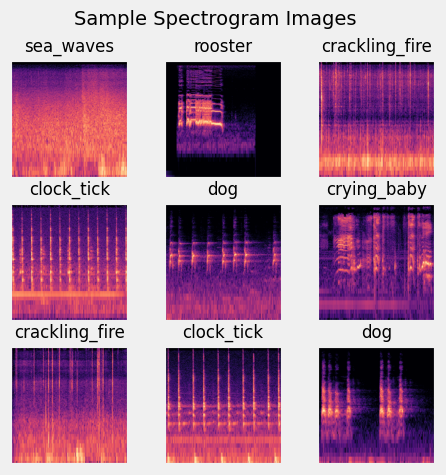

In [15]:
# examples of full spectrogram representations of the 5 sec audio recordings
w, h = 5, 5
fig = plt.figure(figsize=(w, h))
columns, rows = 3, 3

for i in range(1, columns*rows +1):
    row = dataset_df.sample(1).iloc[0]
    # convert base64 string back to pillow image
    msg = base64.b64decode(row['spectrogram'])
    buf = BytesIO(msg)
    img = Image.open(buf)
    
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.title(row['category'], fontsize=12)
    plt.xticks([])
    plt.yticks([])
plt.suptitle("Sample Spectrogram Images", fontsize=14)
plt.show()

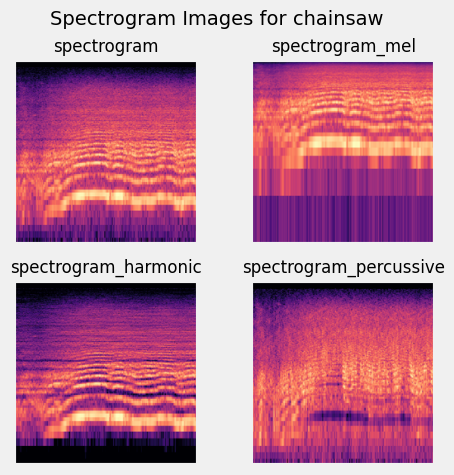

In [20]:
# Show all 4 spectrogram representations of a 5 sec audio recording 
show_specs(dataset_df.iloc[2], figsize=(5, 5))

In [18]:
# save featurized dataset to csv
dataset_df.to_csv("./esc10_featurized.csv", index=False)

## 2. Modeling

### Create a multiclass project

Create a project and build models to predict the classification target.

In [18]:
dr.__version__

'3.0.2'

Note that image datasets are larger files and commonly take longer than tabular datasets to upload. Speed of upload may depend on multiple factors. 

In [19]:
project_name = 'High Frequency MultiClass using Spectrogram images and STFT numerics'
project = dr.Project.create('./esc10_featurized.csv',
                            project_name=project_name)

In [20]:
# the 'fold' feature in the dataset predefines 5 partitions
# also set fold value 5 as the holdout partition
project.set_partitioning_method(cv_method=dr.enums.CV_METHOD.USER,
                                validation_type="CV",
                                user_partition_col='fold',
                                cv_holdout_level=5)

Project(High Frequency MultiClass using Spectrogram images and STFT numerics)

We turn off the flag to prepare a model for deployment to allow further model evaluation before deciding on a model to deploy. See the <a href='https://datarobot-public-api-client.readthedocs-hosted.com/en/v3.0.2/autodoc/api_reference.html?highlight=advancedoptions#advanced-options'>API Reference page</a> for additional advanced project settings.

In [21]:
advanced_options = dr.AdvancedOptions(prepare_model_for_deployment=False)

### Start Autopilot

In [22]:
project.analyze_and_model(target='category',
                          mode=dr.AUTOPILOT_MODE.FULL_AUTO,
                          worker_count = -1,
                          advanced_options=advanced_options)

Project(High Frequency MultiClass using Spectrogram images and STFT numerics)

In [ ]:
# To access an existing project set your project ID below
# project = dr.Project.get("project_id alpha numeric")

In [23]:
# view project in GUI - helpful for viewing training progress
project.get_uri()

'https://app.datarobot.com/projects/64123e5dd54c6f87a26ee60e/models'

In [ ]:
# ensure autopilot has finished before proceeding
project.wait_for_autopilot()

### Get the top-performing model

In [48]:
leaderboard_top = get_top_of_leaderboard(project)

Unique blueprints tested: 14
Feature lists tested: 1
Models trained: 14
Blueprints in the project repository: 34


Top models in the leaderboard:


,model_id,model,pct,validation,cross_validation
0,64123f9201f1339b62cbe027,eXtreme Gradient Boosted Trees Classifier,60.0,0.30445,0.394137
1,64123f9201f1339b62cbe026,Light Gradient Boosted Trees Classifier (SoftM...,60.0,0.29819,0.430982
2,64123f9201f1339b62cbe02a,Light Gradient Boosted Trees Classifier (SoftM...,60.0,0.32068,0.437023
3,64123f9201f1339b62cbe024,Regularized Logistic Regression (L2),60.0,0.28787,0.458550
4,64123f9201f1339b62cbe01f,Keras Residual Neural Network Classifier using...,60.0,0.30451,0.461253


In [50]:
# get the model at the top of the leaderboard, according to the cross validation LogLoss score
top_model = dr.Model.get(project=project.id, model_id=leaderboard_top.iloc[0].model_id)
top_model

Model('eXtreme Gradient Boosted Trees Classifier')

## 3. Model evaluation

### Visualize model performance

In [51]:
conf_chart = top_model.get_confusion_chart(dr.enums.CHART_DATA_SOURCE.CROSSVALIDATION, 
                                            fallback_to_parent_insights=True)
perf_df = pd.DataFrame(conf_chart.class_metrics)[['class_name','actual_count','predicted_count',
                                                  'f1','recall','precision']]
perf_df

,class_name,actual_count,predicted_count,f1,recall,precision
0,chainsaw,32,32,0.968750,0.96875,0.968750
1,clock_tick,32,33,0.984615,1.00000,0.969697
2,crackling_fire,32,33,0.892308,0.90625,0.878788
3,crying_baby,32,30,0.935484,0.90625,0.966667
4,dog,32,30,0.903226,0.87500,0.933333
5,helicopter,32,28,0.766667,0.71875,0.821429
6,rain,32,31,0.730159,0.71875,0.741935
7,rooster,32,34,0.939394,0.96875,0.911765
8,sea_waves,32,35,0.895522,0.93750,0.857143
9,sneezing,32,34,0.939394,0.96875,0.911765


Text(0.5, 1.0, 'Cross Validation Confusion Matrix')

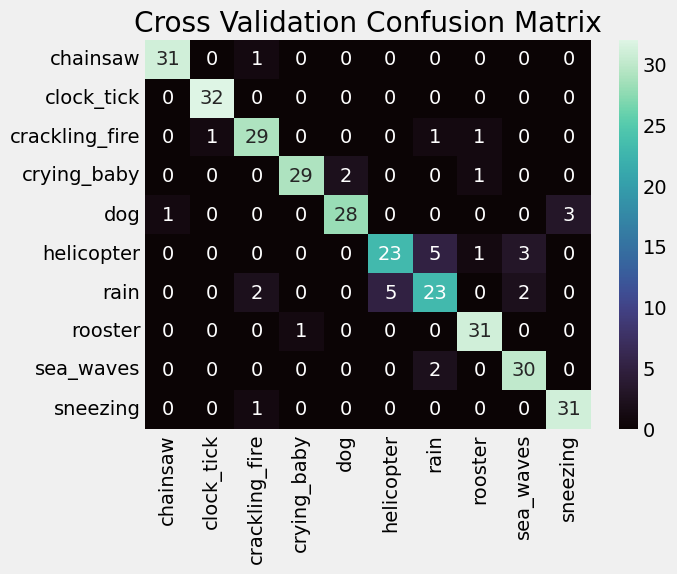

In [52]:
hm = pd.DataFrame(conf_chart.confusion_matrix)
hm.columns = conf_chart.classes
hm.index = conf_chart.classes
sns.heatmap(hm, annot=True, cmap='mako')
plt.title('Cross Validation Confusion Matrix')

### Activation Maps

Create activation maps with a trained data sample.

In [53]:
# compute activation maps for the top model
job_status_url = ImageActivationMap.compute(project.id, top_model.id)
print(status_url)  # view status in this url
print(project.get_uri())  # or watch in the gui

https://app.datarobot.com/api/v2/projects/64123e5dd54c6f87a26ee60e/jobs/44/
https://app.datarobot.com/projects/64123e5dd54c6f87a26ee60e/models


In [ ]:
job_id = job_status_url.split("/")[-2]
job = dr.models.Job.get(project.id, job_id)
job.wait_for_completion()

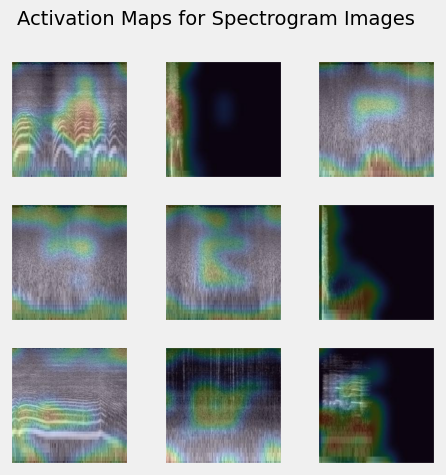

In [56]:
w, h = 5, 5
fig = plt.figure(figsize=(w, h))
columns, rows = 3, 3

activation_maps = ImageActivationMap.list(project.id, top_model.id, 'spectrogram')[:rows*columns+1]

for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    activation_map = activation_maps[i]
    bio = BytesIO(activation_map.overlay_image.image_bytes)
    img = Image.open(bio)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.suptitle("Activation Maps for Spectrogram Images", fontsize=14)
plt.show()

### Feature Impact analysis

Feature Impact
(<a href='https://docs.datarobot.com/en/docs/modeling/analyze-models/understand/feature-impact.html#feature-impact'>Feature Impact</a>) is available for all model types and works by altering input data and observing the effect on a model’s score. It is an on-demand feature, meaning that you must initiate a calculation to see the results. Once you have had DataRobot compute the feature impact for a model, that information is saved with the project.

Feature Impact measures how important a feature is in the context of a model. That is, it measures how much the accuracy of a model would decrease if that feature were removed.

Note that the diversity of features created is providing signal to the model.

This tool is useful for assessing the value/predictive power of the computed image and numeric features.

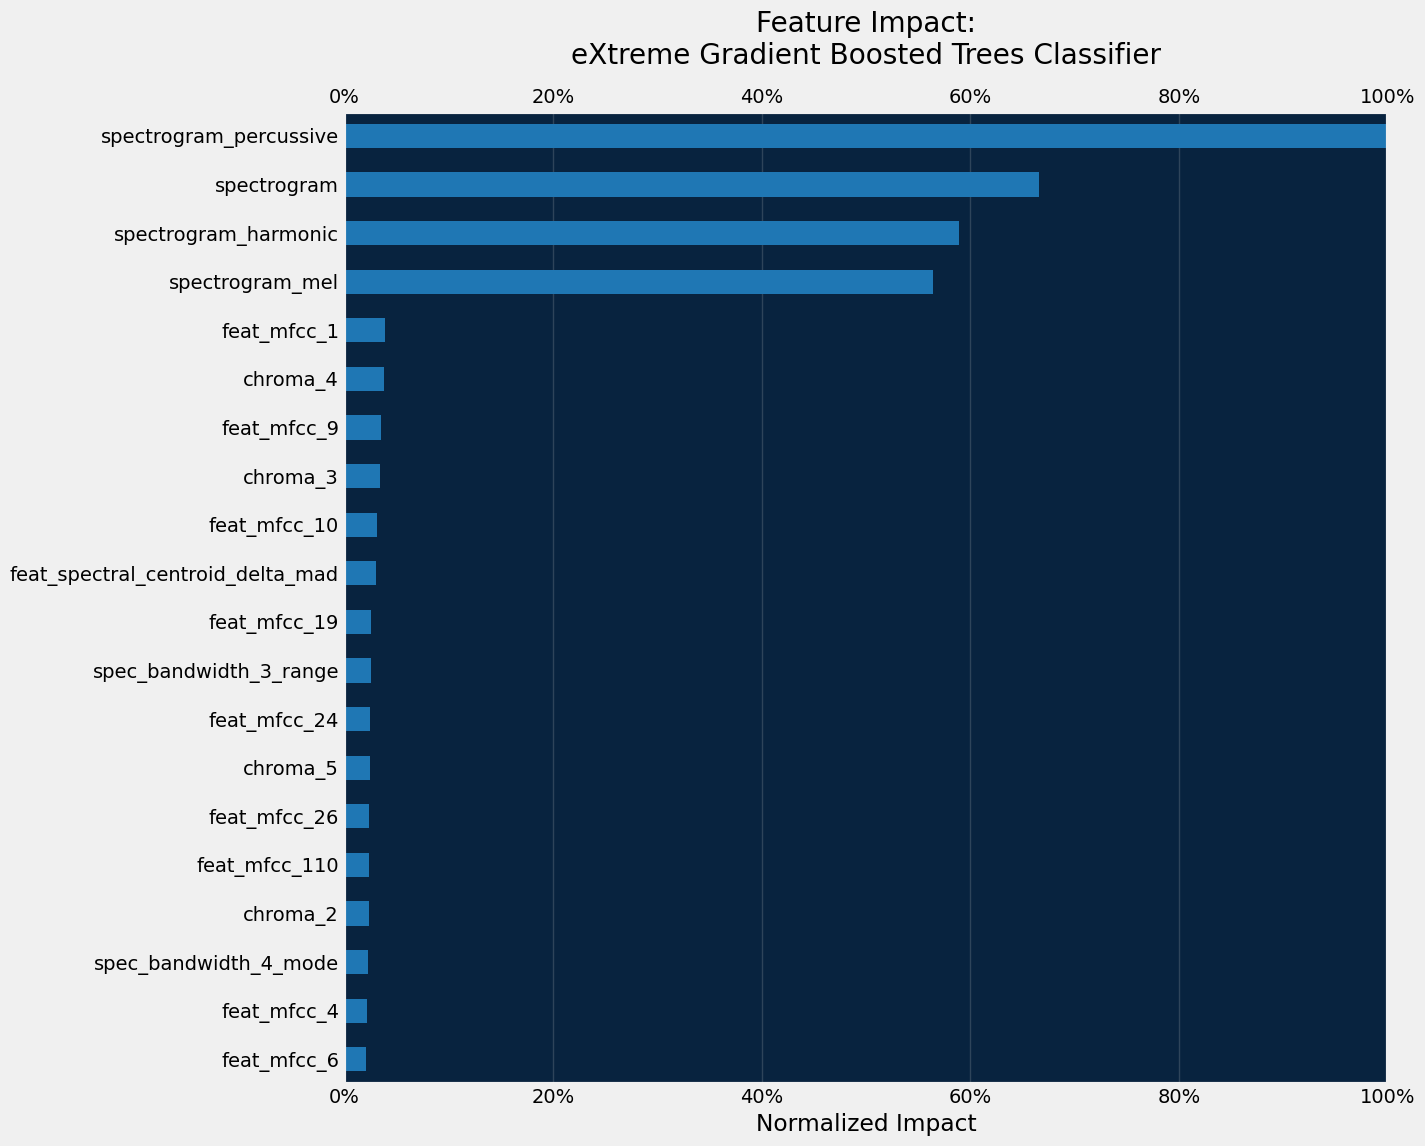

In [60]:
plot_feature_impacts(top_model, top_n=20)  # requests feature impact plot calc if not already available

In [61]:
# create a new feature list using the top n most impactful features for the top model
max_num_features = 4
time_to_wait_for_impact = 4 * 60  # seconds

feature_impacts = top_model.get_or_request_feature_impact(time_to_wait_for_impact)

feature_impacts.sort(key=lambda x: x['impactNormalized'], reverse=True)
final_names = [f['featureName'] for f in feature_impacts[:max_num_features]]

featurelist_highest_impact = project.create_featurelist(f'top_{max_num_features}', final_names)

In [62]:
# train a model with the top features using the same blueprint/model architecture of the top model
model_job_id = top_model.train(featurelist_id=featurelist_highest_impact.id,
                               scoring_type=dr.SCORING_TYPE.cross_validation)
fi_model = dr.models.modeljob.wait_for_async_model_creation(project.id, model_job_id, max_wait=600)
fi_model

Model('eXtreme Gradient Boosted Trees Classifier')

In [64]:
# get the cross validation LogLoss scores for each model to compare
top_model_cv_ll = np.array(list(top_model.get_cross_validation_scores()['cvScores']['LogLoss'].values())).mean()
fi_model_cv_ll = np.array(list(fi_model.get_cross_validation_scores()['cvScores']['LogLoss'].values())).mean()
print('autopilot top model CV LogLoss score: {:.4}\nfeature impact model CV LogLoss score: {:.4}'
      .format(top_model_cv_ll, fi_model_cv_ll))

autopilot top model CV LogLoss score: 0.3941
feature impact model CV LogLoss score: 0.4358


The top model from the autopilot process with access to all of the features outperforms the model retrained with the 4 most impactful features. Despite the feature impact plot being dominated by the 4 image features, the numerics add additional value here. 

### Conclusion

This notebook's workflow provides a repeatable framework from project setup through model evaluation for an acoustic classification use-case classifying environment sounds. The image and numeric feature engineering techniques used here are applicable to any high frequency data sources. Featurizing parameter tweaking and additional feature computation can be added to the `Featurizer` object in `create_features.py`. Model evaluation tools such as assessing image activations and feature impact plots provide insights into how a trained model leverages the engineered features for predictions.

As in the example presented here, numerics often provide increase predictive power over images alone. However, finding the optimal set of input features is a matter of trial and error, and exploring several combinations of top features (top 20, top 10, image only, etc.) are recommended for maximizing model accuracy. The code here supports rapid iteration with featurelist creation and model retraining. The Appendix section includes links and example code for exploring variations of spectrogram generation. Lastly, the DataRobot platform contains many adjustable hyperparameters for model tuning and the image blueprints in particular often exhibit improvement after tuning with variations on the image featurizer and featurizer granularity levels. Please refer to the <a href='https://app.datarobot.com/docs/modeling/special-workflows/visual-ai/vai-reference/vai-tuning-guide.html'>Visual AI tuning guide</a> for a step-by-step walkthrough (through the GUI) for improving image projects. 

## Appendix

The code below can be used for analyzing individual wav files as a time series signal (audioform) and in the frequency domain (spectrogram).
Additionally, variations on spectrogram creation can be explored to qualitatively assess which parameters present the signal most comprehensively. Variations to explore include <a href='https://librosa.org/doc/main/core.html#magnitude-scaling'>magnitude scaling</a> (`amplitude`, `db_to_power`, etc.) and <a href='https://librosa.org/doc/main/generated/librosa.display.specshow.html#'>frequency types</a> (`linear`, `log`, `cqt_hz`, etc.) for the x and y axes of the <a href='https://librosa.org/doc/main/auto_examples/plot_display.html#sphx-glr-auto-examples-plot-display-py'>specshow</a> function.

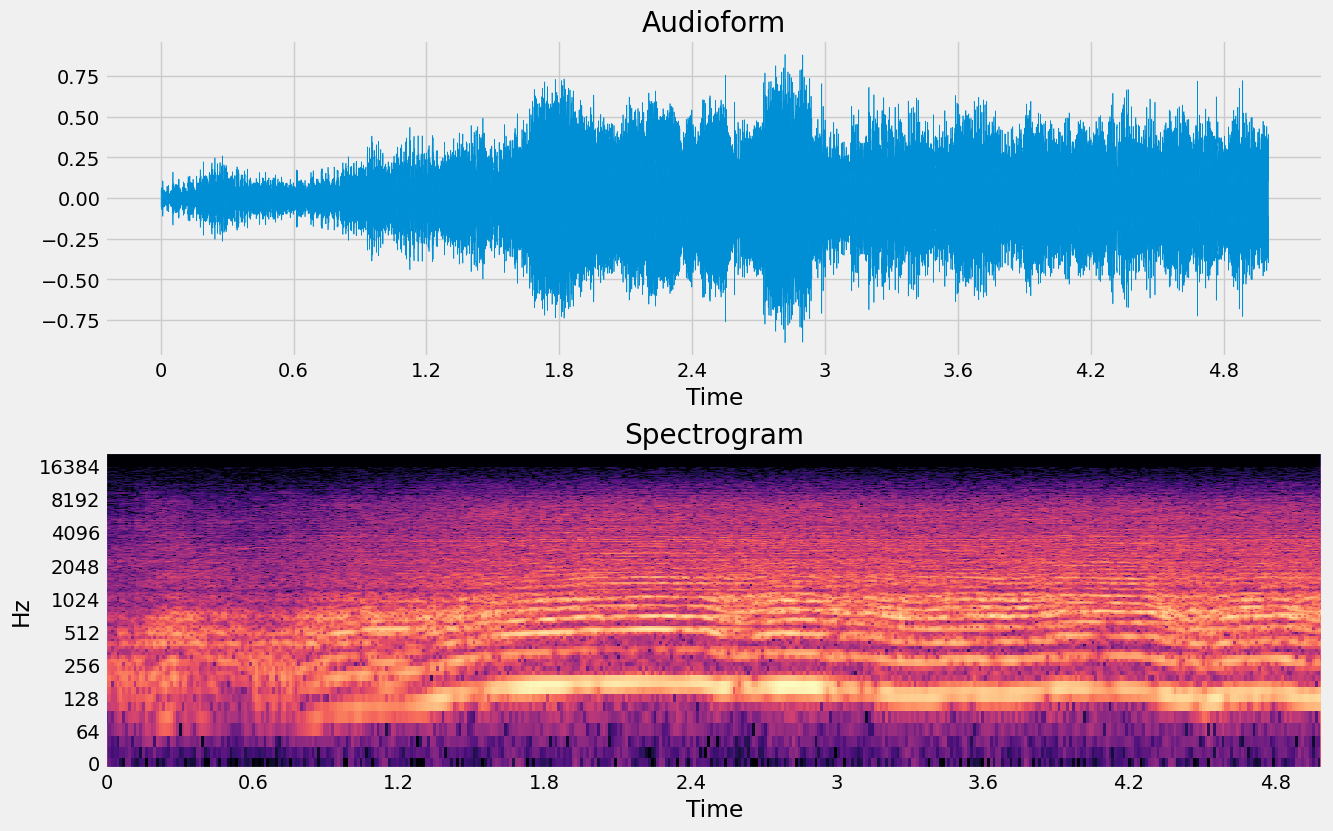

In [22]:
plt.figure(figsize=(14, 9))
plt.figure(1)

plt.subplot(211)
plt.title('Audioform')
librosa.display.waveshow(y, sr=sr)

plt.subplots_adjust(hspace=0.3)

plt.subplot(212)
plt.title('Spectrogram')
y, sr_ = librosa.load(os.path.join(data_dir, features_df.iloc[2]['filename']), sr=sr)
S = np.abs(librosa.stft(y, n_fft=n_fft))
S_db = librosa.amplitude_to_db(S, ref=np.max)
librosa.display.specshow(S_db, x_axis='time', y_axis='log', sr=sr)